**Project "Link analysis"**




Author: Daria Soboleva

Matriculation number: 967410





Goal of the project:  implement a ranking system to dataset

Data source: [«Amazon US Customer Review»](http://https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset) dataset

Chosen category: Books

In [1]:
pip install kaggle


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "dashasoboleva12"
os.environ['KAGGLE_KEY'] = "10920d011833cc161028393855cac336"


In [3]:
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset -f amazon_reviews_us_Books_v1_02.tsv

100% 1.25G/1.25G [00:46<00:00, 37.8MB/s]
100% 1.25G/1.25G [00:46<00:00, 29.0MB/s]


In [4]:

import numpy as np
import pandas as pd
import networkx as nx
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [5]:
dataset_path = '/content/amazon_reviews_us_Books_v1_02.tsv.zip'

books_data = pd.read_csv(dataset_path, delimiter='\t', compression='zip', error_bad_lines=False)

Skipping line 1680001: expected 15 fields, saw 22



**Data Preparation and Analysis**

In [ ]:
books_data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4.0,2.0,3.0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3.0,5.0,5.0,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4.0,1.0,22.0,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5.0,2.0,2.0,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4.0,0.0,2.0,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14


In [ ]:
# Number of rows and columns
books_data.shape

(3105370, 15)

In [ ]:
books_data.dtypes

marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent         int64
product_title         object
product_category      object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
dtype: object

In [ ]:
books_data.isnull().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          0
product_category       0
star_rating            4
helpful_votes          4
total_votes            4
vine                   4
verified_purchase      4
review_headline       42
review_body            4
review_date          133
dtype: int64

In [ ]:
import plotly.express as px
rating_counts = books_data['star_rating'].value_counts()
fig = px.bar(x=rating_counts.index,y=rating_counts.values)
fig.show()

In [ ]:
print("\nTotal # of Reviews :",books_data.shape[0])
print("Total # of Users   :", (len(books_data['customer_id'].value_counts())))
print("Total # of Products   :", (len(books_data['product_id'].value_counts())))


Total # of Reviews : 3105370
Total # of Users   : 1502331
Total # of Products   : 779714


In [ ]:
n_of_reviews_per_customer= books_data.groupby(by='customer_id')['star_rating'].count().sort_values(ascending=False)

n_of_reviews_per_customer.head()

customer_id
50122160    21922
50732546     9963
52615377     2664
45041039     2215
50776149     1797
Name: star_rating, dtype: int64

In [ ]:
n_of_reviews_per_customer.describe()

count    1.502331e+06
mean     2.067032e+00
std      2.194374e+01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.192200e+04
Name: star_rating, dtype: float64

In [ ]:
n_of_reviews_per_product = books_data.groupby(by='product_id')['star_rating'].count().sort_values(ascending=False)

n_of_reviews_per_product.head()

product_id
043935806X    4625
0439139597    3739
0525947647    2665
0895260174    2615
0385504209    2583
Name: star_rating, dtype: int64

In [ ]:
n_of_reviews_per_product.describe()

count    779714.000000
mean          3.982699
std          17.276999
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        4625.000000
Name: star_rating, dtype: float64

In [ ]:
print('Product that recieved max. number of reviews:', n_of_reviews_per_product.idxmax())
print('Customer who gave max. number of reviews:', n_of_reviews_per_customer.idxmax())

Product that recieved max. number of reviews: 043935806X
Customer who gave max. number of reviews: 50122160


In [13]:
product_id = "043935806X"
product_title = books_data.loc[books_data['product_id'] == product_id, 'product_title'].iloc[0]

print(product_title)

Harry Potter and the Order of the Phoenix (Book 5)



**CUSTOMER BASED RANKING SYSTEM**



In [6]:
import pandas as pd
import networkx as nx

# Transforming the dataset into DataFrame
books_df = pd.DataFrame.from_dict(books_data)



In [7]:
# Droping the irrelevant columns from the DataFrame
columns_to_drop = ['marketplace', 'review_id', 'product_parent', 'product_title', 'product_category',
                   'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
                   'review_headline', 'review_body', 'review_date']
books_df = books_df.drop(columns_to_drop, axis=1)

In [8]:
books_df.head()

,customer_id,product_id
0,12076615,0385730586
1,12703090,0811828964
2,12257412,1844161560
3,50732546,0373836635
4,51964897,0262181533


In [11]:
# Calculating # of reviews per customer
customer_review_counts = books_df['customer_id'].value_counts()

# Limiting our dataset
top_n_customers = 500

# Choosing customer IDs for the top customers
top_customers = customer_review_counts.head(top_n_customers).index.tolist()

# Filtering the dataset to include only top customers' reviews (with max # of given feedbacks)
filtered_df = books_df[books_df['customer_id'].isin(top_customers)]

In [12]:
for customer_id, review_count in zip(top_customers, customer_review_counts[top_customers]):
    print(f"Customer ID: {customer_id}, Number of Reviews: {review_count}")

Customer ID: 50122160, Number of Reviews: 21922
Customer ID: 50732546, Number of Reviews: 9963
Customer ID: 52615377, Number of Reviews: 2664
Customer ID: 45041039, Number of Reviews: 2215
Customer ID: 50776149, Number of Reviews: 1797
Customer ID: 50913245, Number of Reviews: 1786
Customer ID: 20595117, Number of Reviews: 1643
Customer ID: 45273033, Number of Reviews: 1622
Customer ID: 39569598, Number of Reviews: 1416
Customer ID: 49693975, Number of Reviews: 1384
Customer ID: 38491967, Number of Reviews: 1336
Customer ID: 36642996, Number of Reviews: 1300
Customer ID: 50881246, Number of Reviews: 1263
Customer ID: 52254603, Number of Reviews: 1158
Customer ID: 51987970, Number of Reviews: 1039
Customer ID: 49750558, Number of Reviews: 1036
Customer ID: 49115690, Number of Reviews: 1023
Customer ID: 50608834, Number of Reviews: 1006
Customer ID: 50068216, Number of Reviews: 997
Customer ID: 51147790, Number of Reviews: 996
Customer ID: 43546353, Number of Reviews: 995
Customer ID: 50

In [11]:
# Create an empty graph
G = nx.Graph()




In [12]:

# Add edges between customers who have reviewed the same product
for _, row in filtered_df.iterrows():
    product_id = row['product_id']
    customers = filtered_df[filtered_df['product_id'] == product_id]['customer_id'].values
    for i in range(len(customers)):
        for j in range(i + 1, len(customers)):
            G.add_edge(customers[i], customers[j])

In [ ]:
# PageRank scores calucation
page_rank = nx.pagerank(G)



In [ ]:
# Sort the customers by PageRank scores
sorted_customers = sorted(page_rank, key=page_rank.get, reverse=True)

# Ranked customers
for customer_id in sorted_customers:
    page_rank_value = page_rank[customer_id]
    print(f"Customer id: {customer_id}, PageRank: {page_rank_value}")

Customer id: 50122160, PageRank: 0.004260285217526671
Customer id: 52615377, PageRank: 0.0039653373756119645
Customer id: 50732546, PageRank: 0.00378846839013077
Customer id: 52938698, PageRank: 0.0035090213028929258
Customer id: 50774468, PageRank: 0.0034477792228368533
Customer id: 51247650, PageRank: 0.00342635960868284
Customer id: 52173832, PageRank: 0.003405699993904634
Customer id: 52564468, PageRank: 0.003404065548123945
Customer id: 50068216, PageRank: 0.003386496143865828
Customer id: 52706646, PageRank: 0.0033394143137315947
Customer id: 50913245, PageRank: 0.0033249480578628173
Customer id: 36642996, PageRank: 0.003309474534167919
Customer id: 39366896, PageRank: 0.0032978089233681417
Customer id: 49042814, PageRank: 0.0032941014360703394
Customer id: 52978794, PageRank: 0.0032806237612760165
Customer id: 12598621, PageRank: 0.0032761954939006166
Customer id: 52947077, PageRank: 0.003273741611436947
Customer id: 52254603, PageRank: 0.0032439110821116555
Customer id: 5121033

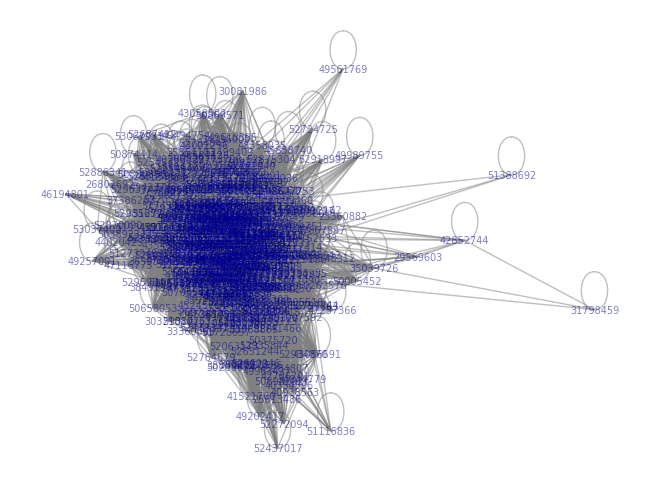

In [ ]:
options = {
    'node_color': 'lightblue',
    'node_size': 0.05,
    'edge_color': 'gray',
    'width': 1,
    'font_color': 'darkblue',
    'font_size': 7,
    'with_labels': True,
    'alpha': 0.5
}

nx.draw(G, **options)

plt.show()

**PRODUCT BASED RANKING SYSTEM**

In [ ]:
min_review_threshold = 15
# Calculate the number of reviews per customer
customer_review_counts = books_df['customer_id'].value_counts()

# Filter the dataset to include only the reviews from customers who meet the minimum review threshold
filtered_df = books_df[books_df['customer_id'].isin(customer_review_counts[customer_review_counts >= min_review_threshold].index)]

# Calculate the number of reviews per product
product_review_counts = filtered_df['product_id'].value_counts()

# Get the product IDs that meet the minimum review threshold
filtered_products = product_review_counts[product_review_counts >= min_review_threshold].index.tolist()

# Filter the dataset to include only the reviews for the filtered products
f_df = filtered_df[filtered_df['product_id'].isin(filtered_products)]

# Droping the irrelevant columns from the DataFrame
columns_to_drop = ['marketplace', 'review_id', 'product_parent', 'product_title', 'product_category',
                   'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
                   'review_headline', 'review_body', 'review_date']
f_df = f_df.drop(columns_to_drop, axis=1)




In [ ]:
num_records = f_df.shape[0]
print(f"Number of records: {num_records}")

Number of records: 166325


In [ ]:
f_df.head

<bound method NDFrame.head of          customer_id  product_id
6           53000124  0805076069
122         50774468  0380007789
123         17136943  1592400876
219         53080748  0446532436
252         45273033  0465023282
...              ...         ...
3104066     53088374  089480829X
3104077     53088374  0671524313
3104627     53092736  0345348656
3104628     53092736  0140157379
3104872     53092251  0140188592

[166325 rows x 2 columns]>

In [ ]:
# Create a new graph
G_new = nx.Graph()


In [ ]:
# Add edges between products that have been reviewed by the same customer
for _, row in f_df.iterrows():
    customer_id = row['customer_id']
    products = f_df[f_df['customer_id'] == customer_id]['product_id'].values
    for i in range(len(products)):
        for j in range(i + 1, len(products)):
            G_new.add_edge(products[i], products[j])


In [ ]:
# Calculate the PageRank scores
page_rank = nx.pagerank(G_new)



In [ ]:
# Sort the products based on the PageRank scores
sorted_products = sorted(page_rank, key=page_rank.get, reverse=True)

# Print the ranked products
for product_id in sorted_products:
    page_rank_value = page_rank[product_id]
    print(f"Product ID: {product_id}, PageRank: {page_rank_value}")

Product ID: 0385504209, PageRank: 0.0013397845210984538
Product ID: 043935806X, PageRank: 0.0012402108175104663
Product ID: 0316666343, PageRank: 0.0012209168283072707
Product ID: 0671027360, PageRank: 0.0012111726468315505
Product ID: 0786868716, PageRank: 0.001105691150852928
Product ID: 0439784549, PageRank: 0.0010845206061419331
Product ID: 0439139597, PageRank: 0.00107959242160257
Product ID: 0452282152, PageRank: 0.0010793865801233527
Product ID: 0590353403, PageRank: 0.0010713595957378857
Product ID: 0316769487, PageRank: 0.0010598254807176225
Product ID: 0156027321, PageRank: 0.0010307465641058316
Product ID: 0066214122, PageRank: 0.0010304872905069573
Product ID: 0679781587, PageRank: 0.0010225462167747351
Product ID: 0439136350, PageRank: 0.0010222915892761535
Product ID: 0399144463, PageRank: 0.001014998066727039
Product ID: 0060392452, PageRank: 0.0010068641834167474
Product ID: 0446310786, PageRank: 0.0009995545123973526
Product ID: 0525947647, PageRank: 0.0009865957623966

In [9]:
product_id = "0316666343"
product_title = books_data.loc[books_data['product_id'] == product_id, 'product_title'].iloc[0]

print(product_title)

The Lovely Bones
